In [1]:
import datetime
import time
import matplotlib.pyplot as plt
import cv2

from solver.Crossword import Crossword
from solver.BPSolver import BPSolver
from utils import puz_to_json, fetch_nyt_crossword
from draw_grid import get_grid

In [2]:
model_path = "./checkpoints/distilbert_EPOCHs_7_COMPLETE.bin"
ans_path = "./checkpoints/all_answer_list.tsv"
dense_embd_path = "./checkpoints/distilbert_7_epochs_embeddings.pkl"
reranker_path = "./checkpoints/t5_small_new_dataset_2EPOCHS"

In [3]:
def solve(crossword, m_path, a_path, d_path, r_path, max_candidate = 40000):
    solver = BPSolver(crossword, model_path = m_path, ans_tsv_path = a_path, dense_embd_path = d_path, reranker_path = r_path, max_candidates = max_candidate)
    solution = solver.solve(num_iters = 60, iterative_improvement_steps = 1)
    return solution
#     solver.evaluate(solution)

In [5]:
date_ = datetime.date(2024, 1, 20)
formatted_date = date_.strftime('%m/%d/%Y')
print(formatted_date)

puzzle = fetch_nyt_crossword(formatted_date)
start_time = time.time()
crossword = Crossword(puzzle)

output = solve(crossword, model_path, ans_path, dense_embd_path, reranker_path, 45000)
end_time = time.time()
print("Total time taken: ", end_time - start_time)


01/20/2024
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
----------------------------------------------------------------------------------------------------------
|                        First Pass: DistilBERT Bi-Encoder with Belief Propagation                       |
----------------------------------------------------------------------------------------------------------

Loopy Belief Propagation Starts.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████|



Loopy Belief Propagation Completed.

First Pass Model Accuracy Report --→ Letters Accuracy: 96.34% | Words Accuracy: 88.89%

----------------------------------------------------------------------------------------------------------
**********************************************************************************************************
----------------------------------------------------------------------------------------------------------
|                            Second Pass: Iterative Improvement with 't5-small'                          |
---------------------------------------------------------------------------------------------------------- 

Getting the uncertain answers
1st Iteration Accuracy Report --→ Letters Accuracy: 97.38% | Words Accuracy: 90.28%

Second Pass Model Accuracy Report (1st Iteration) --→ Letters Accuracy: 97.38% | Words Accuracy: 90.28%

Time Taken by Second Pass Re-ranker Model: 88.31364274024963 seconds.
Re-ranker Model Invoke Count: 1045
Re-ranker Mo

In [38]:
def grid_to_CA_pairs(grid, puzzle):
    
    def get_answer(grid, cell_pos, ans_len, direction = None):
        no_rows = len(grid)
        no_cols = len(grid[0])

        i, j = cell_pos
        word = ''
        
        if direction == 'across':
            for k in range(ans_len):
                word += grid[i][j + k]
        else:
            for k in range(ans_len):
                word += grid[i + k][j]
        return word

    gridnum_to_cell_position = {}
    for i, row in enumerate(puzzle['grid']):
        for j, element in enumerate(row):
            if not isinstance(element, list):
                continue
            else:
                if element[0] != '':
                    gridnum_to_cell_position[element[0]] = (i, j)
                    
    clue_answer_pairs = {}
    for dim in ['across', 'down']:
        for grid_num, clue_ans_pair in puzzle['clues'][dim].items():
            clue, gold_answer = clue_ans_pair
            cell_position = gridnum_to_cell_position[grid_num]
            ans_len = len(gold_answer)
            grid_answer = get_answer(grid, cell_position, ans_len, dim)
            clue_answer_pairs[clue] = grid_answer
    return clue_answer_pairs
    
test_grid = output['second pass model']['final grid']
grid_to_CA_pairs(test_grid, puzzle)

{"Gardener's item that breaks down a lot": 'COMPOSTLIN',
 'Any member of the order Chiroptera': 'BAT',
 'Plant-based protein brand': 'INCOGMEITO',
 'Mélange': 'HASH',
 "'America's Got Talent' precursor": 'STARSEARCH',
 'Top': 'ACME',
 'Actress Blanchett': 'CATE',
 'Subject for a museum curator': 'ARRHISTORY',
 'Photo finish?': 'OPS',
 "'Goooooooooool!,' e.g.": 'CRY',
 'Not now!': 'THEN',
 'Points the finger at': 'IDS',
 "'Good goin'!'": 'ATTABOY',
 'Plans a getaway for, perhaps': 'ABETS',
 'Beverage with an oxymoronic name': 'FIREWATER',
 'Stentorian': 'LOUD',
 'Something that may be hard to drink?': 'CIDER',
 '___ bag': 'TOTE',
 'Lacking bells and whistles': 'BAREBONES',
 'Like the smell of burned rubber': 'ACRID',
 'Got ready': 'RIPENED',
 "'It's a secret'": 'SHH',
 'Signature items': 'PENS',
 'Sweet ___': 'PEA',
 'Tried to take a seat?': 'RAN',
 'Dead-tree edition': 'PRINTISSUE',
 "It's on the house": 'EAVE',
 "Paul who was People's 2021 Sexiest Man Alive": 'RUDD',
 'Bad drawing?': 

In [ ]:
# output['first pass model']['grid']
for row in puzzle['grid']:
    for element in row:
        if isinstance(element, list):
            print(element[1], end = '  ')
        else:
            print('#', end = '  ')
    print()
puzzle['grid']

In [21]:
first_pass_solution = output['first pass model']['grid']
lett_accu, word_accu = output['first pass model']['letter accuracy'], output['first pass model']['word accuracy']
accuracy_list = [lett_accu, word_accu]
first_pass_img = get_grid(first_pass_solution, puzzle, accuracy_list)

grid_img_solutions = [(first_pass_img, 'First Pass Model - Output')]

if 'second pass model' in output.keys():
    for i, grid_solution in enumerate(output['second pass model']['all grids']):
        lett_acc = output['second pass model']['all letter accuracy'][i]
        word_acc = output['second pass model']['all word accuracy'][i]
        solved_grid = get_grid(grid_solution, puzzle, [lett_acc, word_acc])
        grid_img_solutions.append((solved_grid, f'{i+1}th Iteration - Output'))
        

15 15
(259, 15)
15 15
(259, 15)


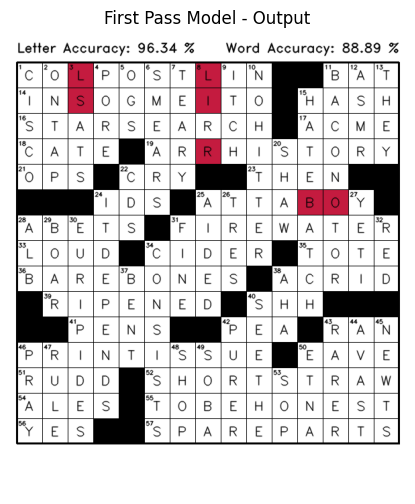

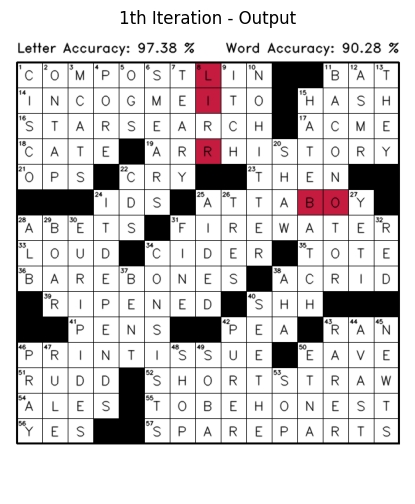

In [22]:
for img_solution, title_name in grid_img_solutions:
    gray = cv2.cvtColor(img_solution, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (6, 6))
    plt.imshow(gray)
    plt.axis('off')
    plt.title(title_name)
    plt.show()